---

# Problem 4: Neural style transfer (30 points)

In this problem, we will use deep learning to compose one image in the style of another image. This is known as [neural style transfer](https://towardsdatascience.com/a-brief-introduction-to-neural-style-transfer-d05d0403901d) and the technique is outlined in paper [A Neural Algorithm of Artistic Style (Gatys et al.)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

![inputs](https://www.tensorflow.org/tutorials/generative/style_transfer_files/output__UWQmeEaiKkP_0.png)
![output](https://www.tensorflow.org/tutorials/generative/style_transfer_files/output_iYSLexgRKSh-_0.png)

In [10]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

## 4.0 Visualize the inputs

We provide two images, starry.jpg and golden.jpg, for style and content input respectively. To save runtime, we downscale the images to (128,128). You are welcome to play with your own inputs at any resolution scale (note a larger resolution requires more runtime).

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = (128,128)

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("starry.jpg")
content_img = image_loader("golden.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

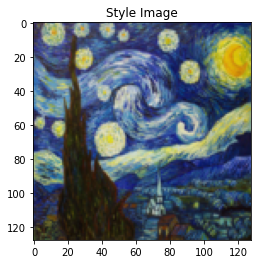

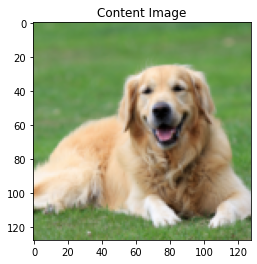

In [13]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 4.1 Loss functions

The cost function has two terms - a content loss term and a style loss term, both of which are explained below.

### 4.1.1 Content Loss

The content of an image is represented by the values of the intermediate feature maps.  This is based on the intuition that images with similar content will have similar representation in the higher layers of the network. Let $p$ and $x$ be the original image and the image that is generated,

<img src="content_loss.png" width="300">

where $P^l$ is the representation of the original image and $F^l$ is the representation of the generated image in the feature maps of layer $l$.

Finish the ContentLoss() to match the corresponding content target representations.

In [14]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):       
        self.loss = F.mse_loss(input, self.target) ## -- ! code required  
        return input


### 4.1.2 Style Loss

The style loss is implemented similarly to the content loss. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix. A gram matrix is the result of multiplying a given matrix by its transposed matrix. 

<img src="gram.png" width="200">


Let $~a$ and $~x$ be the original image and the image that is generated, 

<img src="style_loss.png" width="300">

Here, $A^l$ is the representation of the original image and $G^l$ is the representation of the generated image in layer $l$. $N_l$ is the number of feature maps and $M_l$ is the size of the flattened feature map in layer $l$. $w_l$ is the weight given to the style loss of layer $l$.

Complete the gram_matrix() to alculate a Gram matrix that includes this information and finish the StyleLoss().

In [15]:
def gram_matrix(input):
    i, j, k, l = input.size()
    features = input.view(i * j, k * l)
    G = torch.mm(features, features.t())
    gram = G.div(i * j * k * l)  
    return gram

class StyleLoss(nn.Module):

    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.target = target.detach()
        
    def forward(self, input):        
        self.loss = F.mse_loss(gram_matrix(input), gram_matrix(self.target)) ## -- ! code required  
        return input

### 4.1.3 Import a pre-trained VGG-19.

Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper.

Import a pretrained VGG-19 from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html). Make sure to set the network to evaluation mode using .eval().

In [ ]:
## -- ! code required
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/xiongxinzeng/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
68.9%

### 4.1.4 VGG-19 pre-processing

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 

Complete Normalization() to normalize the image before sending it into the network.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()    
        self.mean = mean.clone().detach()
        self.std = std.clone().detach()

    def forward(self, img):
        # normalize img
        self.mean = torch.tensor(self.mean).view(-1, 1, 1)
        self.std = torch.tensor(self.std).view(-1, 1, 1)
        normalized_img = (img - self.mean) / self.std ## -- ! code required  
        return normalized_img

### 4.1.5 Get content/style representations

Choose intermediate layers from the network to represent the style and content of the image. Use the selected intermediate layers of the model to get the content and style representations of the image. In this problem, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. 

Note the content_layers and style_layers is a list that may containing multiple layers.  Save the corresponding losses into the  content_losses/style_losses list.

Complete the get_style_model_and_losses() so you can easily extract the intermediate layer values.

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, content_layers, style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            ## -- ! code required  
            content = model(content_img).detach()
            content_loss = ContentLoss(content)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            # add style loss:
            ## -- ! code required  
            content_style = model(style_img).detach()
            style_loss = StyleLoss(content_style)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses

## 4.2 Build the model

### 4.2.1 Perform the neural transfer
 
Finally, we must define a function that performs the neural transfer. To transfer the style of an artwork $~a$ onto a photograph $~p$ we synthesise a new image that simultaneously matches the content representation of $~p$ and the style representation of $~a$. Thus we jointly minimise the distance of the feature representations of an initial image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network. The loss function we minimise 

<img src="total_loss.png" width="400">

where α and β are the weighting factors for content and
style reconstruction, respectively. If there were multiple selected layers, just simply sum up the corresponding losses with an equal weight.

For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The paper recommends LBFGS, but Adam works okay, too.

Compelte the run_style_transfer().

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1,
                       content_layers=content_layers_selected,
                       style_layers=style_layers_selected):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layers, style_layers)

    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.1, eps=1e-1)

    
    print('Optimizing..')
    step_i = 0
    while step_i <= num_steps:
        input_img.data.clamp_(0, 1)
        
        ## -- ! code required  
        optimizer.zero_grad()

        model(input_img)
        content_score = 0
        style_score = 0

        for content_loss in content_losses:
          content_score += content_loss.loss
        for style_loss in style_losses:
          style_score += style_loss.loss
        
        content_score *= content_weight
        style_score *= style_weight

        loss = style_score + content_score
        loss.backward()
        optimizer.step()

        step_i += 1
        if step_i % 50 == 0:
            print("run {}:".format(step_i))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### 4.2.2 Test your model

Now you have done your coding tasks, let's test them!

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

## 4.3 Content/style loss weight ratio

Try two different style loss weights: 5000 and  10. Discuss what you learn from the results.

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=5000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=10
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

We maintain the same intermediate layers for style representations and content representations. Compared to the second experiment, the first one with much larger style_weight-versus-content_weight ratio makes each step for the training much more significant and perform a better output. 

## 4.4 Choose different intermediate layers

Try three different intermediate layers for style representations: conv_1, conv_3 and conv_5. Discuss what you learn from the results.

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/Users/xiongxinzeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/Users/xiongxinzeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run 50:
Style Loss : 107.217918 Content Loss: 29.927433

run 100:
Style Loss : 25.675920 Content Loss: 29.187119



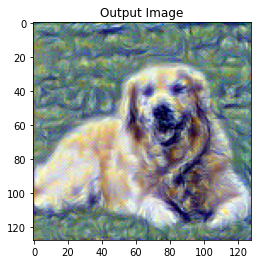

In [17]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_3']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_5']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()

As the selected_style_layer goes further in vgg19 model, both stye loss and content loss become larger and the style-loss-versus-content-loss are much larger. As selected_style_layer goes deeper with the same selected_content_layer, the output image is more inclined to the artistic style. 